# Model module tutorial

This tutorial is a part of Model module guide. Here, we explore how you can use the OnnxModel wrapper to use your Onnx deep learning models in the benchmark.

In [1]:
# If you are executing this notebook at a location different than root, you need to add it to
# the path.
import sys
sys.path.insert(0,'../../')

In [2]:
# Python packages
import gc
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [3]:
# Auxiliary packages
import keras
import torch
import tensorflow as tf

from tensorflow.gfile import GFile

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [4]:
# Onnx related
import onnx
import tf2onnx
import keras2onnx

In [5]:
# Matlab engine
try:
    import matlab.engine
except ImportError as err:
    print(err)

# Matlab engine
eng = matlab.engine.start_matlab()

In [6]:
# Benchmark modules
from OpenDenoising import data
from OpenDenoising import model
from OpenDenoising import evaluation

In [7]:
data.download_BSDS_grayscale(output_dir="../../tmp/BSDS500/")

2019-09-12 17:25:12,458 : WARNING : OpenDenoising.data : Directory ../../tmp/BSDS500/Train/ref already exists. Download was aborted. Check if the data was already downloaded.
2019-09-12 17:25:13,213 : WARNING : OpenDenoising.data : Directory ../../tmp/BSDS500/Valid/ref already exists. Download was aborted. Check if the data was already downloaded.


In [8]:
# Validation images generator
valid_generator = data.DatasetFactory.create(path="../../tmp/BSDS500/Valid",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config={data.utils.gaussian_noise: [25]},
                                             name="BSDS_Valid")

In [9]:
def display_results(clean_imgs, noisy_imgs, rest_images, name):
    """Display denoising results."""
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    
    plt.suptitle("Denoising results using {}".format(name))

    for i in range(5):
        axes[i, 0].imshow(np.squeeze(clean_imgs[i]), cmap="gray")
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Ground-Truth")

        axes[i, 1].imshow(np.squeeze(noisy_imgs[i]), cmap="gray")
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Noised Image")

        axes[i, 2].imshow(np.squeeze(rest_imgs[i]), cmap="gray")
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Restored Images")

# Onnx Model <a class="anchor" id="onnx-model"></a>
---

This notebook covers how OnnxModel class can be used to hold Deep Learning models, and to perform inference. We remark that Onnx is a framework focused on deploying trained neural networks, hence, there is no support for training models in this format.

# Navigation
---

* [Charging a model](#onnx-charging-a-model)
    * [From a .onnx file](#import-onnx)
* [Running inference](#onnx-running-inference)
* [Converting models to Onnx](#convert-to-onnx)
    * [Keras to Onnx](#keras2onnx)
    * [Pytorch to Onnx](#pyt2onnx)
    * [Tensorflow to Onnx](#tf2onnx)
    * [Matlab to Onnx](#mlab2onnx)

## Charging a model <a class="anchor" id="onnx-charging-a-model"></a>
---

The charging can only be done by the specification of a ".onnx" file, which holds the model's computational graph as well as weights. To perform inference, we rely on [onnxruntime module](https://github.com/microsoft/onnxruntime) for Python.

After charging a model into OnnxModel, a onnxruntime session is created so that you can perform inference.

In [10]:
onnx_model_ex1 = model.OnnxModel(model_name="DnCNN_onnx")
onnx_model_ex1.charge_model(model_path="./Additional Files/Onnx Models/dncnn.onnx")

## Running Inference <a class="anchor" id="onnx-running-inference"></a>
---

Inference can be done by using the "\_\_call\_\_" method required by the AbstractDeepLearningModel interface. This method ensures that derived classes (as OnnxModel) can be used a function. Bellow, a batch of noisy/clean images is drawn from the dataset, and the OnnxModel used to predict the restored image,

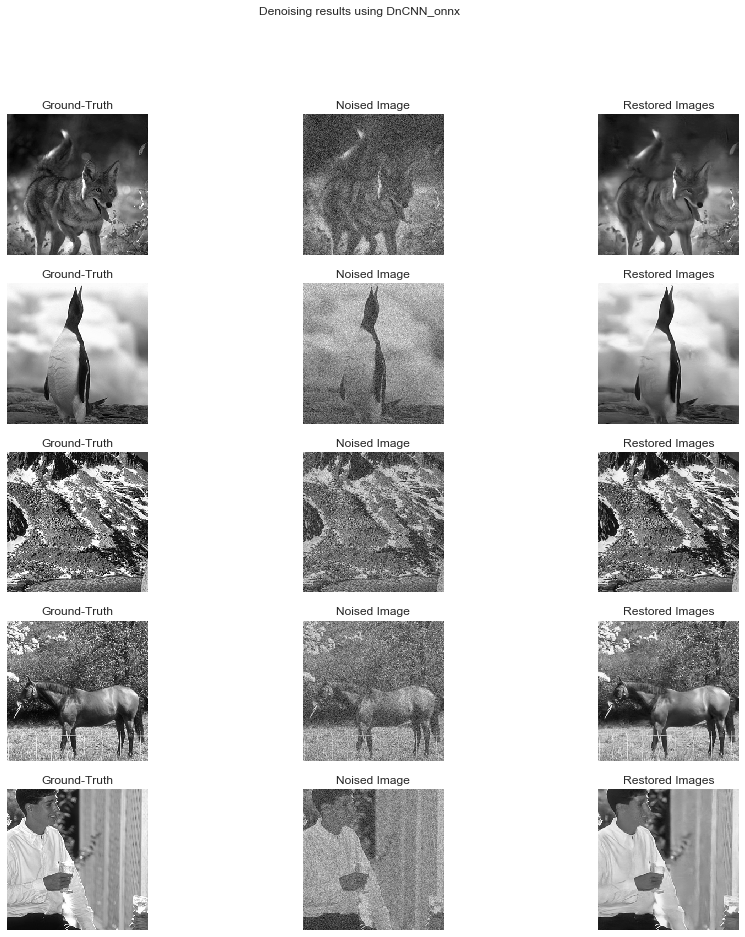

In [11]:
# Get batch from valid_generator
noisy_imgs, clean_imgs = next(valid_generator)
# Performs inference on noisy images
rest_imgs = onnx_model_ex1(noisy_imgs)
# Display results
display_results(clean_imgs, noisy_imgs, rest_imgs, str(onnx_model_ex1))

## Converting models to Onnx <a class="anchor" id="convert-to-onnx"></a>
---

[Onnx](https://onnx.ai/) is thought as a bridge between different Deep Learning frameworks. It is used to deploy models for inference (assuming they were trained previously).

Each language has its own way of converting its models into Onnx. Some of them, such as [Pytorch](https://pytorch.org/docs/stable/onnx.html) and [Matlab](https://fr.mathworks.com/help/deeplearning/ref/importonnxnetwork.html), have such support natively. Others, rely on non-official modules such as [keras2onnx](https://github.com/onnx/keras-onnx) or [tf2onnx](https://github.com/onnx/tensorflow-onnx).

### Keras to Onnx <a class="anchor" id="keras2onnx"></a>

In [12]:
# Loads Keras model
keras_model = keras.models.load_model("./Additional Files/Keras Models/dncnn.hdf5")
# Converts Keras model to Onnx
onnx_model = keras2onnx.convert_keras(keras_model, "myModel")
# Saves Onnx model
onnx.save(onnx_model, "./Additional Files/Onnx Models/dncnn_from_keras.onnx")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


/home/efernand/anaconda3/envs/OpenDenoisingEnv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Pytorch to Onnx <a class="anchor" id="pyt2onnx"></a>

In [13]:
# Loads torch model
torch_model = torch.load("./Additional Files/Pytorch Models/dncnn.pth")
dummy = torch.randn(5, 1, 40, 40, device="cuda")
torch_model = torch_model.cuda()
torch.onnx.export(torch_model, dummy, "./Additional Files/Onnx Models/dncnn_from_pytorch.onnx",
                  input_names=["input"], output_names=["output"])

ModuleNotFoundError: No module named 'model'

In [ ]:
# Loads onnx file from Pytorch
onnx_model = onnx.load("./Additional Files/Onnx Models/dncnn_from_pytorch.onnx")
print("[Graph Input] name: {}, shape: {}".format(onnx_model.graph.input[0].name, 
                                                 [dim.dim_value for dim in onnx_model.graph.input[0].type.tensor_type.shape.dim]))
print("[Graph Output] name: {}, shape: {}".format(onnx_model.graph.output[0].name, 
                                                  [dim.dim_value for dim in onnx_model.graph.output[0].type.tensor_type.shape.dim]))

Notice that the past two tensors are of fixed size (both batch size, height and width). We address this problem in the next section.

#### Note on Pytorch2Onnx

Since Pytorch does not support [dynamic shapes](https://github.com/onnx/onnx/issues/654) (i.e. None values in shape), the exported Onnx model will have fixed shape, which can be problematic at inference (you can only process images by slicing them into fixed-sized patches).

However, there is a turn-around for such problem, that is to process Onnx graph and switch the height/width values for "?" values (analogous to None in Tensorflow/Keras).

If you face problems with fixed-sized inputs, you can use the model.utils module for conversion:

In [ ]:
model.utils.onnx_dynamic_shapes("./Additional Files/Onnx Models/dncnn_from_pytorch.onnx",
                                "./Additional Files/Onnx Models/dncnn_from_pytorch_dyn_shapes.onnx",
                                channels_first=True)

In [ ]:
# Loads onnx file from Pytorch
onnx_model_dyn_shapes = onnx.load("./Additional Files/Onnx Models/dncnn_from_pytorch_dyn_shapes.onnx")
print("New graph:")
print("[Graph Input]\n {}".format(onnx_model_dyn_shapes.graph.input[0]))
print("[Graph Output] name: {}".format(onnx_model_dyn_shapes.graph.output[0]))

### Tensorflow to Onnx <a class="anchor" id="tf2onnx"></a>

In order to convert a Tensorflow model to Onnx, you need to convert all its variables to constants. To do so, the __model.utils__ module has a function called __freeze_tf_graph__ that converts all the variables in the __current__ Tensorflow graph to constants.

You can either specify a model_file (containing your Tensorflow Model) to be read and frozen, or let the function get the default graph and session. In the first case, the default graph is expected to be empty (that is, you have not previously defined any tensorflow computation).

In this example, we will freeze the Tensorflow model present on "./Additional Files/Tensorflow Models/from_saved_model".

In [ ]:
# Note that, in the previous sections, we have loaded a graph using Keras.
# With tf.reset_default_graph, we can reset Tensorflow's computational graph.
tf.reset_default_graph()

In [ ]:
model.utils.freeze_tf_graph(model_file="./Additional Files/Tensorflow Models/from_saved_model/saved_model.pb",
                            output_filepath="./Additional Files/Tensorflow Models/frozen_model.pb",
                            output_node_names=["output"])

In [ ]:
# Note that, in the previous function, we have loaded the graph in saved_model.
# With tf.reset_default_graph, we can reset Tensorflow's computational graph.
tf.reset_default_graph()

In [ ]:
model.utils.pb2onnx(path_to_pb="./Additional Files/Tensorflow Models/frozen_model.pb",
                    path_to_onnx="./Additional Files/Onnx Models/dncnn_from_tf.onnx",
                    input_node_names=["input"], output_node_names=["output"])

### Matlab to Onnx <a class="anchor" id="mlab2onnx"></a>

Once you have trained your model using [Matlab's Deep Learning Toolbox](https://www.mathworks.com/products/deep-learning.html), you should either a network object on your workspace, or a .mat file saved on a folder.

Taking the last case as example, we consider the file "./Additional Files/Matlab Models/dncnn_matlab.mat" previously trained. In order to convert it to Onnx, you can either do it from Python (by using matlab's engine) or directly on Matlab. Keep in mind that every command run with engine.evalc is a pure matlab command.

In [14]:
eng.evalc("load('./Additional Files/Matlab Models/dncnn_matlab.mat');")

''

In [16]:
print(eng.workspace)

In [15]:
eng.evalc("exportONNXNetwork(net, './Additional Files/Onnx Models/dncnn_from_matlab_tb.onnx')")

''